# Ecuaciones diferenciales

El objetivo del análisis numérico de ecuaciones diferenciales es proveer una solución numérica de una ecuación diferencial de la forma:

$$\dot{x} = f(t,x)$$

con $x_0=x(0)$ dado y $f$ conocida. 

En general para una $f$ genérica, el problema anterior no puede resolverse explícitamente, por lo que se busca calcular $x(t_k)$ en una grilla adecuada de valores de $t_k$.

## Método de Euler

Una primera aproximación al problema es utilizar el *método de Euler* que consiste en realizar la siguiente aproximación numérica:

$$x(t+h) \approx x(t) + f(t,x(t)) h.$$

Sin embargo, este método presenta problemas de estabilidad si $h$ no es suficientemente pequeño, o la ecuación amplifica errores, como vimos.

Buscamos ahora una formulación más general del problema que permita encontrar métodos más eficientes.

### Formulación integral del método de Euler

En la deducción del método de Euler, se buscó aproximar la trayectoria de $x(t)$ mediante una recta. Sin embargo, también podemos ver el problema de manera integral, lo que habilita a utilizar métodos más generales.

La ecuación diferencial establece que:

$$\dot{x} = f(t,x).$$

Si integramos lo anterior entre $t$ y $t+h$ obtenemos:

$$x(t+h) - x(t) = \int_t^{t+h} \dot{x}(s)ds = \int_t^{t+h} f(s,x(s)) ds.$$

El método de Euler consiste entonces en aproximar la última integral por un rectángulo usando el valor de $f$ al comienzo del intervalo:

$$\int_t^{t+h} f(s,x(s)) ds \approx f(t,x(t)) h.$$

Por lo cual:

$$x(t+h) \approx x(t) + f(t,x(t)) h.$$

Sin embargo, cambiando el método de aproximación de la integral, podemos obtener diferentes algoritmos de solución. Veremos dos a continuación: *Euler implícito* y *Método del trapecio*.

## Método de Euler implícito

En el método de Euler implícito, se parte de la formulación integral:

$$x(t+h) = x(t) + \int_t^{t+h} f(s,x(s)) ds,$$

y se aproxima la integral anterior por un rectángulo, al igual que Euler, pero utilizado el valor *final* del intervalo, es decir:

$$\int_t^{t+h} f(s,x(s)) ds \approx f(t+h,x(t+h))h.$$

Si ahora estamos resolviendo en una grilla, luego de obtenido el punto $t_k,x_k$, se toma $t_{k+1} = t_k+h$ y se debe hallar $x_{k+1}$ resolviendo:

$$x_{k+1} = x_k + f(t_{k+1},x_{k+1}) h.$$

En esta ecuación, $x_{k+1}$ aparece de forma *implícita* (es decir, sin despejar), lo que le da nombre al método.

**Problema:** si $f$ es complicada, puede no ser posible despejar $x_{k+1}$ analíticamente, por lo que necesitamos una estrategia numérica para resolver lo anterior


### Estrategia predictor-corrector

Esta estrategia consiste en lo siguiente:

* Establecer una aproximación inicial de $x_{k+1}$ mediante un método no implícito (ej: Euler).
* Refinar la aproximación anterior iterando la ecuación que define $x_{k+1}$ hasta obtener convergencia.

Es una aplicación del Método Iterativo General que vimos para ec no lineales a este problema particular.

### Algoritmo Euler implícito

Para un problema de ec. diferenciales con $f$ dada, $x(0)$ dado y paso $h$ hacemos:

1. Inicialización: $k=0$, $x_0=x(0)$, $t_0 = 0$.

2. En el paso $k$, definimos $t_{k+1}=t_k+h$ y estimamos $\tilde{x}_{k+1} = x_k + h f(t_k,x_k)$.

3. Luego se itera: $\tilde{x}_{k+1} \leftarrow x_k + h f(t_{k+1},\tilde{x}_{k+1})$ hasta convergencia (es decir, la diferencia entre dos $\tilde{x}_{k+1}$ consecutivos es menor que cierta tolerancia).

4. Al terminar la iteración anterior, se toma $x_{k+1} = \tilde{x}_{k+1}$ (el estimado final), se asigna $k\leftarrow k+1$ y se vuelve a $2$.

El algoritmo termina al cubrir todo el intervalo. Si alguna de las iteraciones intermedias no converge, se produce un error.

### Implementación

In [1]:
using LinearAlgebra

#Aplica el metodo de euler implicito. Recibe como parámetros la función f, 
#la condición inicial, el paso y los extremos del intervalo a resolver. 
#Devuelve una grilla de puntos t,x que aproximan a la solución.
function euler_implicito(f,x0,h,T0,Tfinal)
    
    #condición inicial
    t=T0;
    x=x0;
    
    #defino un vector donde guardar la grilla de puntos y lo inicializo con la condición inicial.
    T=[t];
    X=[x];
    
    #tolerancia para uso interno
    tol=1e-4;
    maxiter=20;
    
    #iteracion principal
    while(t+h<Tfinal)
        
        #candidato inicial para x_{k+1}
        candidato=x+h*f(t,x);
        
        #actualizo el t
        t=t+h;
        
        #itero hasta convergencia. paso arranca en Inf para que entre una vez al while.
        paso=Inf;
        j=0;
        while(paso>tol && j<maxiter)
            candidato_anterior=candidato;
            candidato = x + h*f(t,candidato_anterior);
            paso = norm(candidato-candidato_anterior);
            j=j+1;
        end
        #al salir del while, el candidato es el nuevo x, si corta por iteraciones da un error.
        if(j>=maxiter && paso >tol)
            error("El corrector no converge en t=$t, x=$x")
        else
            x = candidato;
        end
        
        #lo agrego a la salida
        push!(T,t);
        push!(X,x);
    end
    
    return T,X;
end;

### Ejemplo

Consideramos el siguiente sistema lineal de primer orden:

$$\dot{x} = -ax, \quad x(0)=x_0.$$

La solución explícita de este sistema puede calcularse y es:

$$x(t) = x_0 e^{-at}.$$

Utilizamos ahora el método de Euler implícito para resolverlo, con $x_0=2.0$, $a=2.0$ y $h=0.1$.

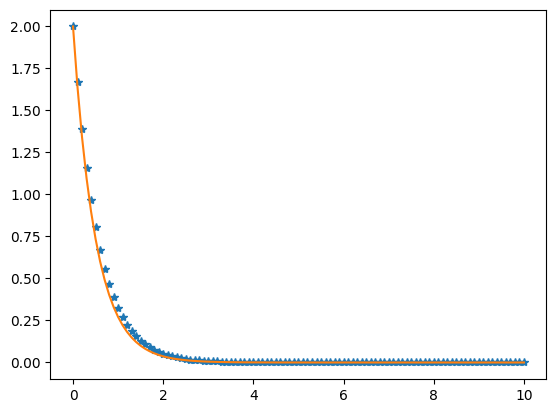

In [2]:
using PyPlot

#Defino la función. En este caso solo depende de x.
a=2;
f(t,x)=-a*x;

#Condición inicial.
x0=2.0;

#paso e intervalo de trabajo.
h=0.1;
t0=0.0;
T=10.0;

t,x = euler_implicito(f,x0,h,t0,T)

#Grafico la estimación y la solución oficial
plot(t,x,"*");
plot(t,x0*exp.(-a*t));

### Ventajas de Euler implícito:

* A diferencia de Euler, este método es estable para un rango mayor de $h$. 
* En particular, en el problema anterior, si $a>0$ (sistema estable), entonces la iteración es estable para todo $h>0$.

### Desventajas:

* El uso de predictor/corrector hace que la iteración interna de corrección pueda no converger.
* En particular, en el problema anterior, si $h>1/a$ el método en teoría converge, pero la iteración interna no.
* Se debe buscar otra estrategia para resolver la ecuación implícita.

## Método del trapecio

En el método del trapecio se parte nuevamente de la formulación integral:

$$x(t+h) = x(t) + \int_t^{t+h} f(s,x(s)) ds,$$

y se aproxima la integral anterior por un trapecio utilizando ambos extremos:

$$\int_t^{t+h} f(s,x(s)) ds \approx \frac{h}{2}\left[f(t,x) + f(t+h,x(t+h))\right].$$

Si ahora estamos resolviendo en una grilla, luego de obtenido el punto $t_k,x_k$, se toma $t_{k+1} = t_k+h$ y se debe hallar $x_{k+1}$ resolviendo:

$$x_{k+1} = x_k + \frac{h}{2}[f(t_k,x_k) + f(t_{k+1},x_{k+1})].$$

Nuevamente, $x_{k+1}$ aparece de forma *implícita* (es decir, sin despejar), por lo que nuevamente debemos usar la estrategia predictor-corrector.

**Ventaja:** La aproximación por trapecio tiene un error local de orden $h^3$ (el de Euler es $h^2$) por lo que el error de aproximación es menor para un mismo $h$.


### Algoritmo de Trapecio

Para un problema de ec. diferenciales con $f$ dada, $x(0)$ dado y paso $h$ hacemos:

1. Inicialización: $k=0$, $x_0=x(0)$, $t_0 = 0$.

2. En el paso $k$, definimos $t_{k+1}=t_k+h$ y estimamos $\tilde{x}_{k+1} = x_k + h f(t_k,x_k)$.

3. Luego se itera: $\tilde{x}_{k+1} \leftarrow x_k + \frac{h}{2}[f(t_k,x_k) +  f(t_{k+1},\tilde{x}_{k+1})]$ hasta convergencia (es decir, la diferencia entre dos $\tilde{x}_{k+1}$ consecutivos es menor que cierta tolerancia).

4. Al terminar la iteración anterior, se toma $x_{k+1} = \tilde{x}_{k+1}$ (el estimado final), se asigna $k\leftarrow k+1$ y se vuelve a $2$.

El algoritmo termina al cubrir todo el intervalo. Si alguna de las iteraciones intermedias no converge, se produce un error.

### Implementación

In [3]:
#Aplica el metodo del trapecio. Recibe como parámetros la función f, 
#la condición inicial, el paso y los extremos del intervalo a resolver. 
#Devuelve una grilla de puntos t,x que aproximan a la solución.
function trapecio(f,x0,h,T0,Tfinal)
    
    #condición inicial
    t=T0;
    x=x0;
    
    #defino un vector donde guardar la grilla de puntos y lo inicializo con la condición inicial.
    T=[t];
    X=[x];
    
    #tolerancia para uso interno
    tol=1e-4;
    maxiter=20;
    
    #iteracion principal
    while(t+h<Tfinal)
        
        #candidato inicial para x_{k+1}
        candidato=x+h*f(t,x);
        
        #itero hasta convergencia. paso arranca en Inf para que entre una vez al while.
        paso=Inf;
        j=0;
        while(paso>tol && j<maxiter)
            candidato_anterior=candidato;
            candidato = x + (f(t,x) + f(t+h,candidato_anterior))*h/2;
            paso = norm(candidato-candidato_anterior);
            j=j+1;
        end
        #al salir del while, el candidato es el nuevo x, si corta por iteraciones da un error.
        if(j>=maxiter && paso >tol)
            error("El corrector no converge en t=$t, x=$x")
        else
            x = candidato;
        end
        #actualizo el t
        t=t+h;
        
        #lo agrego a la salida
        push!(T,t);
        push!(X,x);
    end
    
    return T,X;
end;

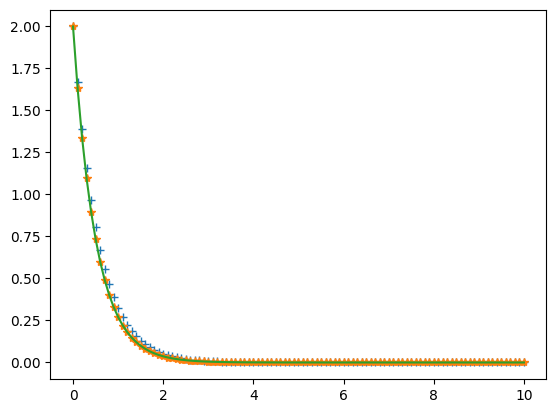

In [4]:
#Defino la función. En este caso solo depende de x.
a=2;
f(t,x)=-a*x;

#Condición inicial.
x0=2.0;

#paso e intervalo de trabajo.
h=0.1;
t0=0.0;
T=10.0;

t,x = euler_implicito(f,x0,h,t0,T);
t_trap,x_trap = trapecio(f,x0,h,t0,T);

#Grafico la estimación y la solución oficial
plot(t,x,"+");
plot(t_trap,x_trap,"*")
plot(t,x0*exp.(-a*t));

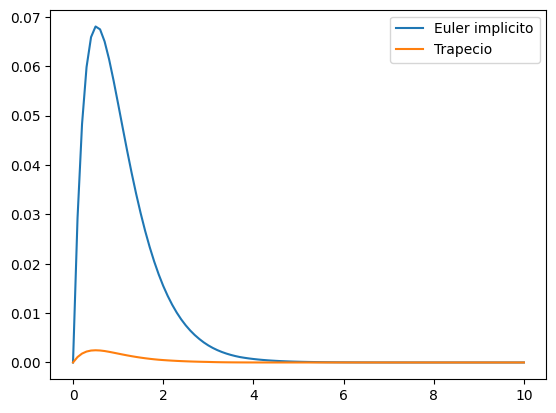

In [5]:
##Comparamos la estimacion

plot(t,abs.(x-x0*exp.(-a*t)),label="Euler implicito")
plot(t_trap,abs.(x_trap-x0*exp.(-a*t_trap)),label="Trapecio")
legend();

## Métodos de orden mayor: Runge-Kutta

Con la misma idea del método del trapecio, pueden derivarse métodos de orden mayor, aproximando la integral por curvas más adecuadas.

Los métodos Runge-Kutta son una familia paramétrica que permite incrementar el orden de la estimación aumentando la cantidad de evaluaciones en puntos intermedios.

No veremos como funciona, pero sí como invocar este tipo de métodos en Julia utilizando el paquete `DifferentialEquations.jl`.

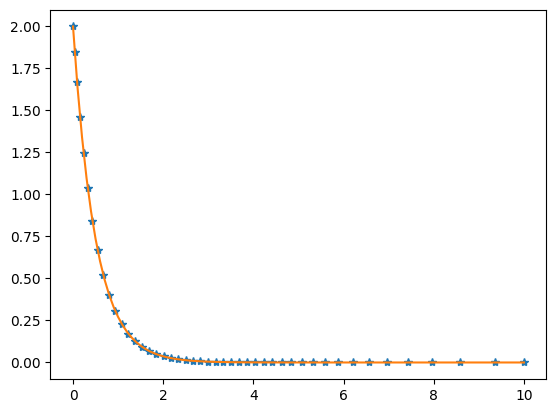

In [6]:
using DifferentialEquations

#Defino la función. En este caso solo depende de x.
#El paquete Differential Equations pide que f sea de la forma f(x,p,t)
#donde p es un vector de parámetros. En este caso el a.
f(x,p,t)=-p*x;

#Condición inicial.
x0=2.0;

#Valor del parámetro
a=2;

#Intervalo de trabajo.
t0=0.0;
T=10.0;

#se define el problema (los parametros de f van al final)
prob = ODEProblem(f,x0,(t0,T),a)

#se resuelve el problema usando el Metodo de Runge-Kutta de orden 4.
sol = solve(prob,RK4());

plot(sol.t,sol.u,"*")
plot(t,x0*exp.(-a*t));


### Paso adaptivo

**Observación:** El método del paquete `DifferentialEquations.jl` presenta una ventaja adicional: posee un paso adaptivo. Es decir: ajusta el valor de $h$ a la concavidad de la solución. Esto le permite un control mayor de la precisión.

En la gráfica se muestra el valor de $t_{k+1} - t_k$ en cada paso de la solución. A medida que la solución llega al equilibrio, el paso se vuelve mayor.

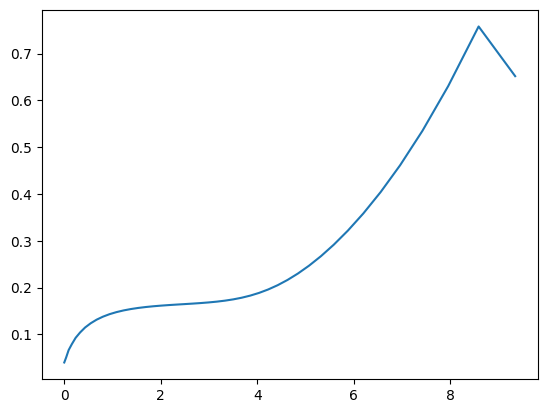

In [7]:
plot(sol.t[1:end-1],diff(sol.t));

El paso adaptivo genera un problema: el vector de tiempos `sol.t` no necesariamente está equiespaciado. Para evaluar la solución en una grilla equiespaciada debemos invocar a `solve` con el parámetro `saveat=h` para que salve la solución cada paso $h$.

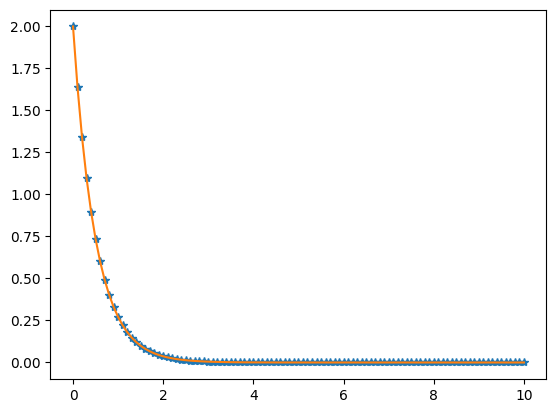

In [8]:
sol = solve(prob,RK4(), saveat=h);

plot(sol.t,sol.u,"*")
plot(t,x0*exp.(-a*t));


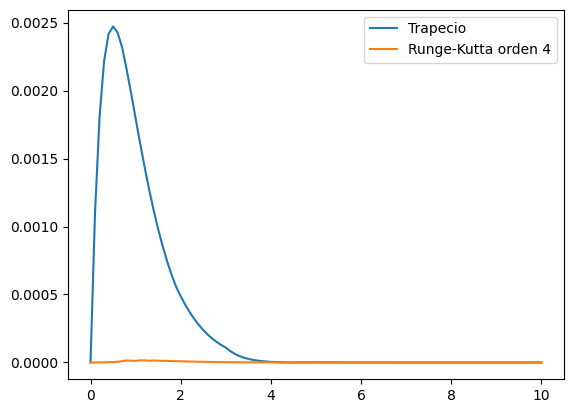

In [9]:
#Comparacion del error con el metodo del trapecio
plot(t_trap,abs.(x_trap-x0*exp.(-a*t_trap)),label="Trapecio")
plot(sol.t,abs.(sol.u-x0*exp.(-a*sol.t)),label="Runge-Kutta orden 4")

legend();


## El caso vectorial

Todos los métodos discutidos anteriormente funcionan también si $x\in\mathbb{R}^n$, es decir, una ecuación vectorial de cualquier orden. Podemos utilizar esto para simular sistemas físicos.

### Ejemplo:

Consideremos nuevamente el péndulo de largo $L$, sujeto a un campo gravitatorio de constante $g$. La ecuación del péndulo es:

$$\ddot{\theta} = - \frac{g}{L} \sin(\theta).$$

siendo $\theta$ el ángulo. Normalmente esta ecuación se analiza linealizando alrededor de $\theta=0$, pero con el método anterior podemos resolverla numéricamente.

## Ejercicio

1. Escriba la ecuación anterior utilizando el estado $x = [\theta \; \dot{\theta}]$ en $\mathbb{R}^2$.

2. Resuelva la ecuación anterior para $g/L = 2$ numéricamente, utilizando:
 * Método de Euler implícito
 * Método del Trapecio
 * Método RK4 de Julia.
 
 Discuta el comportamiento de las soluciones en función del paso elegido (para los dos primeros).

3. Agregue rozamiento al péndulo y modifique la ecuaciòn, volviendo a resolver. Compare los errores cometidos, tomando como solución exacta la de RK4.